In [1]:
# imports and defaults

import importlib
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import prettyplot as pp
import cn_derivations as cn
import numpy as np
import os
import data_parser as dp
import math
import mpmath
from timeit import default_timer as timer
import r_function_port as rfp
from sklearn.linear_model import LinearRegression
mpmath.dps = 30
mpmath.pretty = True

pd.options.display.max_rows = 10
import seaborn as sns
sns.set_style('ticks')
sns.set_context('talk')

# Time zone adjustment
import matplotlib
matplotlib.rcParams['timezone'] = 'CET'
os.getcwd()


'/home/nick/PycharmProjects/bkp/ss19-feldkurs/Pycode'

In [2]:
"""Data overview"""
filename = "2019-05-24"
station = "schiessstand"

sdf = dp.scintillometer_parse(filename)
sdf["Cn2"] = (sdf["Cn2"]) / 2032**(-3) * 1031.5**(-3)
sdf["H_convection"] = sdf["H_convection"] / 2032**(-3) * 1031.5**(-3)
sdf

,Cn2,CT2,H_convection,crosswind,sigCrosswind,pressure,temp,humidity,pathLength,pathHeight,...,<XA>(c),<YA>(c),nSigXA(c),nSigYA(c),corXAYA(c),numDgnValid,numDgnValidCrosswind,numDgnTotal,channelFlagsCombined,error
Time,,,,,,,,,,,,,,,,,,,,,
2019-05-24 05:26:00+02:00,1.461294e-15,0.000193,35.165860,NaN,NaN,1010.0,9.0,81,2032,25.62,...,20451.6,20609.4,0.010469,0.011068,-0.004,1,0,1,0,1
2019-05-24 05:27:00+02:00,1.870824e-15,0.000248,42.046137,NaN,NaN,1010.0,9.0,81,2032,25.62,...,20465.4,20579.2,0.013037,0.013001,0.120,2,0,2,0,1
2019-05-24 05:28:00+02:00,2.000249e-15,0.000265,44.339563,NaN,NaN,1010.0,9.0,81,2032,25.62,...,20346.9,20589.7,0.012148,0.013691,0.048,2,0,2,0,1
2019-05-24 05:29:00+02:00,2.266287e-15,0.000300,48.926414,NaN,NaN,1010.0,9.0,81,2032,25.62,...,20477.3,20494.0,0.013917,0.013173,0.016,2,0,2,0,1
2019-05-24 05:30:00+02:00,1.544393e-15,0.000204,36.694811,NaN,NaN,1010.0,9.0,81,2032,25.62,...,20428.3,20515.5,0.012816,0.010916,0.131,2,0,2,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-05-24 16:36:00+02:00,1.141667e-14,0.001511,163.597698,NaN,NaN,1010.0,9.0,81,2032,25.62,...,17427.2,18494.8,0.029496,0.033662,0.093,2,0,2,0,1
2019-05-24 16:37:00+02:00,1.554255e-14,0.002057,205.643835,NaN,NaN,1010.0,9.0,81,2032,25.62,...,17469.0,18561.4,0.037205,0.035720,0.071,2,0,2,0,1
2019-05-24 16:38:00+02:00,1.496537e-14,0.001981,200.292508,NaN,NaN,1010.0,9.0,81,2032,25.62,...,17478.6,18564.7,0.043701,0.037374,0.280,2,0,2,0,1


In [3]:
importlib.reload(cn)
computed_data = cn.data_processor(filename, station)
cdf = computed_data["computed"]
z_eff = {"stable": computed_data["z_eff_stable"], "unstable": computed_data["z_eff_unstable"]}

Mean path height: 31.83766108843537m
Effective path height, stable: 31.34392287277671m
Effective path height, unstable: 25.62897860987237m

Please enter the time at which stable switches to unstable: 0712


/home/nick/PycharmProjects/Feldkurs/ss19-feldkurs/Pycode/cn_derivations.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  g / dataframe["temperature"]) ** (1 / 2)


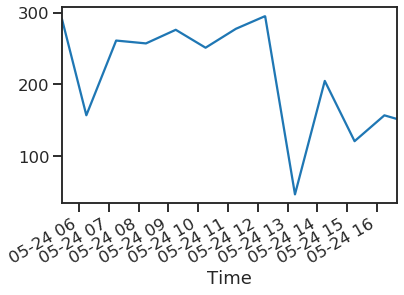

In [5]:
cdf["wind_dir"].plot()

In [ ]:
fig = pp.plot_free_convection(sdf, cdf)
plt.show()

In [6]:
"""Ward's iteration"""
importlib.reload(rfp)

# Takes 100s or so to run
cdf_backup = cdf.copy(deep=True)  # in case of later testing

switch_time = "0557"
computed_data_stable = cn.data_processor(filename, station)

z_eff_s = computed_data["effective_height"]
cdf_stable = computed_data_stable["computed"].iloc[
    cdf.index.indexer_between_time("00:00", switch_time)].copy(deep=True)

cdf_stable = rfp.ward_method(cdf_stable, z_eff, "stable")



Iteration started


/home/nick/miniconda3/envs/py3/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/home/nick/PycharmProjects/Feldkurs/ss19-feldkurs/Pycode/r_function_port.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  "obukhov"].loc[index])
/home/nick/PycharmProjects/Feldkurs/ss19-feldkurs/Pycode/r_function_port.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  dataframe["CT2"].loc[index] * (zm_bl

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [ ]:
cdf_stable

In [ ]:
switch_time = "0557"
computed_data_unstable = cn.data_processor(filename, station)
z_eff_u = computed_data["effective_height"]

cdf_unstable = computed_data_unstable["computed"].iloc[
    cdf.index.indexer_between_time(switch_time, "23:59")].copy(deep=True)

cdf_unstable = rfp.ward_method(cdf_unstable, z_eff_u, "unstable")

In [ ]:
cdf_stable["shf"] = -cdf_stable["shf"]
cdf_stable["obukhov"] = -cdf_stable["obukhov"]

cdf = cdf_stable.append(cdf_unstable,sort=True)

In [ ]:
cdf

In [ ]:
import importlib
importlib.reload(pp)
fig = pp.plot_generic(cdf, "shf")
plt.show()

In [ ]:
header_list = ["year", "month", "day", "hour", "minute", "second", "shf", "windspeed", "obukhov"]
rooftop = pd.read_csv("../../data/weather_data/rooftop.csv",
                           header=None, skiprows=1, index_col=None,
                           names=header_list, sep=",")

t_cols = ['year', 'month', 'day', 'hour', 'minute', "second"]
rooftop.index = pd.to_datetime(rooftop[t_cols])

# Remove the useless columns
rooftop = rooftop.drop(t_cols, axis=1)
rooftop = rooftop.replace(-999, np.nan)
rooftop = rooftop.fillna(method="ffill")

oidx = rooftop.index
nidx = pd.date_range(oidx.min(), oidx.max(), freq='60s')
rooftop = rooftop.reindex(oidx.union(nidx)).interpolate(
    'index').reindex(nidx).tz_localize("UTC")
rooftop.index = rooftop.index + pd.DateOffset(hours=1)
rooftop

In [ ]:
wdf = dp.weather_download("2019-05-24")
wdf = wdf.loc["2019-05-24 03:30":"2019-05-24 15:00"]
wdf

In [ ]:
hourly_cdf = pd.DataFrame()
hourly_cdf["windspeed_mean"] = 0
# hourly_cdf["windspeed_std"] = hourly_cdf["windspeed"].astype("float64").resample("H").std()
hourly_cdf["windspeed_mean"] = cdf["windspeed"].astype("float64").resample("600S").mean()

hourly_roof = pd.DataFrame()
hourly_roof["windspeed_mean"] = 0
# hourly_cdf["windspeed_std"] = hourly_cdf["windspeed"].astype("float64").resample("H").std()
hourly_roof["windspeed_mean"] = rooftop["windspeed"].astype("float64").resample("600S").mean()

fig = plt.figure(figsize=(26, 8))
(cdf["windspeed"]).astype("float64").plot(color="grey", label="Scintillometer")
# hourly_cdf["windspeed_mean"].astype("float64").plot(
#     color="black", linestyle="dashed", label="Scintillometer, hourly mean")

(rooftop["windspeed"]).astype("float64").plot(color="red", linestyle = "dashed", label="InnFLUX, half-hourly mean")
wdf["wg"].astype("float64").plot(color="black", linestyle="dashed", label="ZAMG Hourly Mean")

plt.legend(loc="upper left", fontsize = 20)
plt.xlabel("Time, CET", fontsize = 20)
# plt.ylabel("Mean Wind Speeds, [m$\cdot$s$^{-2}$]", fontsize = 20)
# plt.ylabel("Obukhov Length, [m]", fontsize=20)
# plt.title("Obukhov Lengths for Schießstand, 24$^{th}$ May 2019", fontweight="bold", fontsize = 24)
plt.title("Mean Wind Speeds for Schießstand, 24$^{th}$ May 2019", fontweight="bold", fontsize = 24)
plt.ylabel("Mean Wind Speed, [m$\cdot s^{-2}$]", fontsize=20)
ax = plt.gca()
ax.xaxis.set_major_formatter(
    dates.DateFormatter('%H:%M'))  # hours and minutes
plt.show()

# fig.savefig('./plots/ERTEL/windspeed_series.png', bbox_inches='tight')

In [ ]:
cdf["shf"]

In [ ]:
cdf["shf"].iloc[4:]

In [ ]:
rooftop["shf"].iloc[:611]

In [ ]:
ro = pd.DataFrame()
df_m = pd.DataFrame()
ro = rooftop["shf"].astype(float).resample("0.5H").mean()
df_m = cdf["shf"].astype(float).iloc[4:].resample("0.5H").mean()


In [ ]:
me = pd.DataFrame()
me["roof"] = ro
me["shf"] = df_m


In [ ]:
df = pd.DataFrame()
# df = cdf.filter([""])
df["shf"] = cdf["shf"].iloc[4:].astype("float")
df["roof_shf"] = rooftop["shf"].iloc[:611].astype("float")
df = df.dropna()
X = df["shf"].values.reshape(-1, 1)  # values converts it into a numpy array
Y = df["roof_shf"].iloc[:611].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column

In [ ]:

me = me.dropna()
X = me["shf"].values.reshape(-1, 1)  # values converts it into a numpy array
Y = me["roof"].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column

In [ ]:
df = pd.DataFrame()
# df = cdf.filter([""])
df["obukhov"] = cdf_unstable["obukhov"].iloc[4:].astype("float")
df["roof_ob"] = rooftop["obukhov"].iloc[:611].astype("float")
# df = df[df["obukhov"] !=0]
df = df.dropna()
X = df["obukhov"].values.reshape(-1, 1)  # values converts it into a numpy array
Y = df["roof_ob"].iloc[:611].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column

In [ ]:

fig = plt.figure(figsize=(8, 8))

plt.scatter(X, Y, marker=".", color="black")
plt.title("Sensible Heat Flux Regression for Schießstand, 24$^{th}$ May 2019", fontweight="bold", fontsize = 22)
# plt.xlabel("Scintillometer Flux", fontsize = 20)
plt.ylabel("InnFLUX Sensible Heat Flux, [W$\cdot m^{-2}$]", fontsize = 20)
ax = plt.gca()
ax.set_xlabel("Scintillometer Sensible Heat Flux, [W$\cdot m^{-2}$]", fontsize = 20)

# Linear Regression

linear_regressor = LinearRegression()  # create object for the class
reg = linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X) # make predictions
plt.plot(X, Y_pred, color='black', label="Regression Line")

plt.text(0.05, 0.9, str("R$^{2}$= " + str(round(reg.score(X,Y), 5))), horizontalalignment='left',
     verticalalignment='bottom', transform=ax.transAxes, fontsize=20)
Y1 = X
linear_regressor = LinearRegression()  # create object for the class
reg = linear_regressor.fit(X, Y1)  # perform linear regression
Y1_pred = linear_regressor.predict(X) # make predictions
plt.plot(X, Y1_pred, color='red', label ="1:1 Reference")
plt.legend(loc="lower right")


plt.show()
# 
# fig.savefig('./plots/ZAMG/shf_regression_final.png', bbox_inches='tight')

In [ ]:
hourly_cdf["obukhov_mean"] = 0
# hourly_cdf["shf_std"] = hourly_cdf["shf"].astype("float64").resample("H").std()
hourly_cdf["obukhov_mean"] = cdf["obukhov"].astype("float64").resample("600S").mean()

fig = plt.figure(figsize=(26, 6))
cdf["obukhov"].astype("float64").plot(color="grey", label="Time series")
hourly_cdf["obukhov_mean"].astype("float64").plot(
    color="black", linestyle="dashed", label="10-minute mean")

plt.legend(loc="lower left")
plt.xlabel("Time, CET")
ax = plt.gca()
ax.xaxis.set_major_formatter(
    dates.DateFormatter('%H:%M'))  # hours and minutes
plt.show()

In [ ]:
fig = plt.figure(figsize=(26, 6))
cdf = cdf.tz_convert("UTC")
# sdf["H_convection"].plot(color="black", label="Scintillometer")
cdf["shf"].plot(color="red", label="Iterated Flux")

plt.legend(loc="upper left")
plt.title(
    r"Sensible Heat Fluxes $Q_{H}$ from Scintillometer and from Iteration",
    fontweight="bold")
plt.xlabel("Time")
plt.ylabel("Sensible Heat Flux, [W$\cdot$m$^{-2}$]")
ax = plt.gca()
ax.xaxis.set_major_formatter(
    dates.DateFormatter('%H:%M'))  # hours and minutes

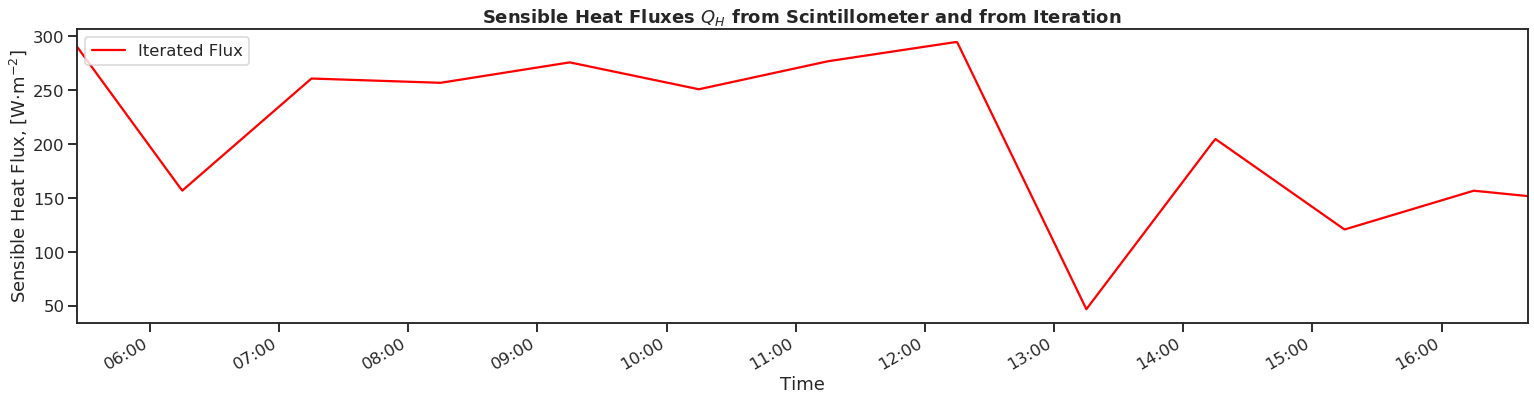

In [6]:
fig = plt.figure(figsize=(26, 6))
cdf = cdf.tz_convert("UTC")
# sdf["H_convection"].plot(color="black", label="Scintillometer")
cdf["wind_dir"].plot(color="red", label="Iterated Flux")

plt.legend(loc="upper left")
plt.title(
    r"Sensible Heat Fluxes $Q_{H}$ from Scintillometer and from Iteration",
    fontweight="bold")
plt.xlabel("Time")
plt.ylabel("Sensible Heat Flux, [W$\cdot$m$^{-2}$]")
ax = plt.gca()
ax.xaxis.set_major_formatter(
    dates.DateFormatter('%H:%M'))  # hours and minutes

In [ ]:
cdf

In [ ]:
cdf_backup = cdf.copy(deep=True)

In [ ]:
cdf = cdf.tz_convert("UTC")

In [ ]:
z_eff

In [ ]:
column_headers = ["yyyy", "MM", "day", "HH", "MM", "zm", "d", "z0",
                  "u_mean", "L", "sigma_v", "u_star", "wind_dir",
                  "temperature, pressure, windspeed, shf, H_free, obukhov"]
ndf = cdf.copy().filter(["wind_dir", "temperature", "pressure", "windspeed", "shf", "H_free", "obukhov"])

ndf["yyyy"] = cdf.index.year
ndf["mm"] = cdf.index.month
ndf["day"] = cdf.index.day
ndf["HH"] = cdf.index.hour
ndf["MM"] = cdf.index.minute
ndf["zm"] = 40.9
ndf["d"] = 0.7 * 12
ndf["z0"] = -999
ndf["u_mean"] = cdf["windspeed"].mean()
ndf["L"] = cdf["obukhov"].fillna(value=-999)
ndf["sigma_v"] = (np.sqrt(((cdf["windspeed"]-ndf["u_mean"])**2)).mean())
ndf["sigma_v"] = ndf["sigma_v"].fillna(value=-999)
ndf["u_star"] = cdf["u_star"].fillna(value=-999)
ndf["wind_dir"] = cdf["wind_dir"].fillna(value=-999)
ndf

In [ ]:
# ndf.to_csv(path_or_buf="../ffp/ffp_midpoint.csv", index=None) 

In [ ]:
column_headers = ["yyyy", "MM", "day", "HH", "MM", "zm", "d", "z0", "u_mean", "L", "sigma_v", "u_star", "wind_dir"]
ndf = cdf.copy().filter("wind_dir")

ndf["yyyy"] = cdf.index.year
ndf["mm"] = cdf.index.month
ndf["day"] = cdf.index.day
ndf["HH"] = cdf.index.hour
ndf["MM"] = cdf.index.minute
ndf["zm"] = 22.5587
ndf["d"] = 0.7 * 12
ndf["z0"] = -999
ndf["u_mean"] = cdf["windspeed"].mean()
ndf["L"] = cdf["obukhov"].fillna(value=-999)
ndf["sigma_v"] = (np.sqrt(((cdf["windspeed"]-ndf["u_mean"])**2)).mean())
ndf["sigma_v"] = ndf["sigma_v"].fillna(value=-999)
ndf["u_star"] = cdf["u_star"].fillna(value=-999)
ndf["wind_dir"] = cdf["wind_dir"].fillna(value=-999)
ndf_backup = ndf.copy()
ndf = ndf.reset_index(drop=True)
ndf
ndf.to_csv(path_or_buf="./rasters/datasets/q825.csv", index=None)

In [ ]:
exdf = cdf.loc[:"2019-05-24 07:55"].copy(deep=True)
exdf.to_csv(path_or_buf="../data/weather_data/schiessstand_bound.csv")